In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-12 14:12:53.427685: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 14:12:53.482102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 14:12:53.482150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 14:12:53.483760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to 

In [2]:
# #Make GP and Simulator class
results = open_file_helper("workspace/4ad8f582072ab96cee11bc3b6aca30f4/BO_Results.gz")
#95d031378d09ba17c4c6b58f8ac05a60
#4ad8f582072ab96cee11bc3b6aca30f4

In [3]:
run = 1
biter = 50
gp_object = copy.copy(results[run-1].list_gp_emulator_class[biter-1])
simulator = copy.copy(results[run-1].simulator_class)
exp_data = copy.copy(results[run-1].exp_data_class)
meth_name = Method_name_enum(results[0].configuration["Method Name Enum Value"])
method = GPBO_Methods(meth_name)
# print(gp_object.train_data_init)
# print(gp_object.noise_std)
# print(simulator.noise_std)
# print(float(scipy.special.polygamma(1, (4*simulator.noise_std**2)/2)))
# print(gp_object.scalerY.lambdas_)

In [4]:
#Scale training data if necessary
feature_train_data_scaled = gp_object.scalerX.transform(gp_object.feature_train_data)
y_train_data_scaled = gp_object.scalerY.transform(gp_object.train_data.y_vals.reshape(-1,1))
y = y_train_data_scaled
# y = gp_object.train_data.y_vals.reshape(-1,1)

Text(0.5, 1.0, 'Histogram of CS17 Train')

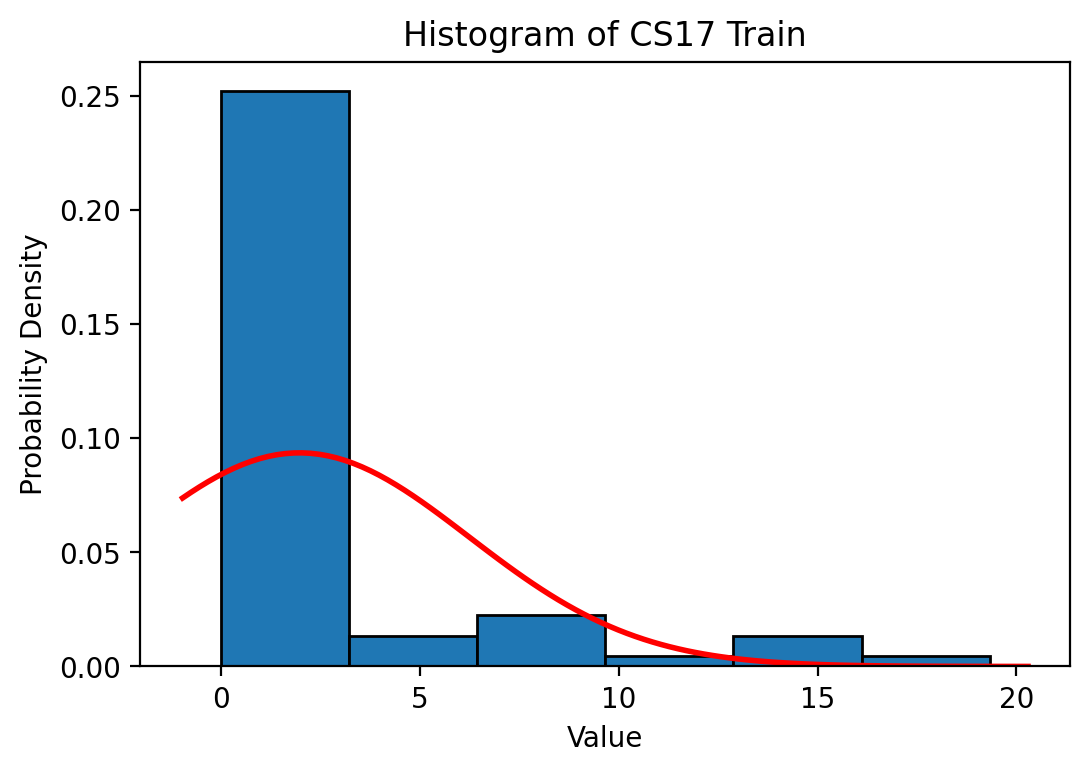

In [5]:
plt.hist(y, bins=int(len(y)/10), density=True, edgecolor='black')  # Adjust the number of bins as needed
xmin, xmax = plt.xlim() 
mu, std = norm.fit(y[~np.isnan(y)])
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 
plt.plot(x, p, 'r', linewidth=2) 


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram of CS17 Train')

In [6]:
#Evaluate gp_mean over x values
#Generate validation data
val_data = simulator.gen_sim_data(15, exp_data.get_num_x_vals(), Gen_meth_enum(1), Gen_meth_enum(2), 1.0, simulator.seed, False)
if method.emulator == False:
    val_data = simulator.sim_data_to_sse_sim_data(method, val_data, exp_data, 1.0, False)
feat_val = gp_object.featurize_data(val_data)

# gp_object.retrain_GP = 25

#Get gp mean
#Change hps of fit gp model or retrain GP
# simulator.noise_std = np.sqrt(float(scipy.special.polygamma(1, (4*simulator.noise_std**2)/2)))
# gp_object.noise_std = None

new_gp_model = gp_object.set_gp_model()
# new_gp_model.kernel.kernels[0].variance.assign(1.19**2)
# new_gp_model.kernel.kernels[0].lengthscales.assign([4.45,4.45,0.417])
# new_gp_model.kernel.kernels[1].variance.assign(0.0013140374228778637)
# gpflow.utilities.set_trainable(new_gp_model.kernel.kernels[0].variance, False)
# gpflow.utilities.set_trainable(new_gp_model.kernel.kernels[0].lengthscales, False)
# gpflow.utilities.set_trainable(new_gp_model.kernel.kernels[1].variance, False)
gp_object.train_gp(new_gp_model)
gpflow.utilities.print_summary(gp_object.fit_gp_model)
# gp_object.fit_gp_model.kernel.kernels[0].variance.assign(1.73)
# gp_object.fit_gp_model.kernel.kernels[0].lengthscales.assign([3.45,3.45])
# gp_object.fit_gp_model.kernel_.k1.k2.length_scale = np.array([3.46, 3.34, 0.708, 3.74, 0.444, 3.5])
# gp_object.fit_gp_model.kernel_.k2.noise_level = 0.0577
# gp_object.fit_gp_model.kernel_.k1.k1.constant_value = 4

misc_gp_mean, misc_var_return = gp_object.eval_gp_mean_var_misc(val_data, feat_val, covar = False)

[1.49875075 0.62708484]
noise 0.28205964487497404
sclr 14.614671268143127
[0.72560332 1.22568327]
noise 0.28205964487497404
sclr 14.614671268143127
[0.75688551 0.0807713 ]
noise 0.28205964487497404
sclr 14.614671268143127
[1.63244682 0.94029174]
noise 0.28205964487497404
sclr 14.614671268143127
[1.47812003 1.63493785]
noise 0.28205964487497404
sclr 14.614671268143127
[0.40618309 0.90060734]
noise 0.28205964487497404
sclr 14.614671268143127
╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                   │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 22.0632   

In [7]:
# print(misc_var_return)

In [8]:
print(gp_object.trained_hyperparams)
gpflow.utilities.print_summary(gp_object.fit_gp_model)
#0.976**2 * Matern(length_scale=[3.46, 3.34, 0.708, 3.74, 0.444, 0.464], nu=2.5) + WhiteKernel(noise_level=0.0577)
#0.965**2 * Matern(length_scale=[3.31, 2.83, 0.667, 2.2, 0.365, 0.395], nu=2.5) + WhiteKernel(noise_level=0.00259)

[array([1.49875075, 0.62708484]), 0.0003724807279252817, 22.063195377579063]
╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                   │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 22.0632                 │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (2,)    │ float64 │ [1.49875    0.62708484] │
├────────────────────────────────────┼───────────┼───────────────

MSE: 17904.998079656558


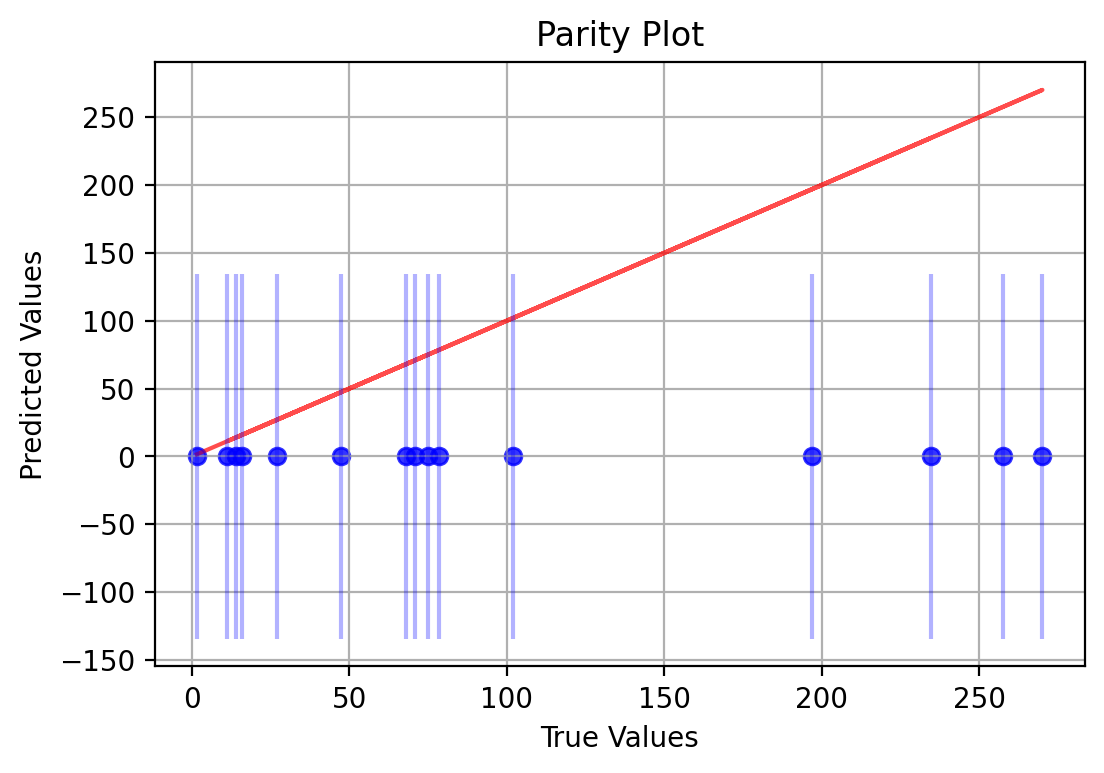

In [9]:
mse= np.sum((val_data.y_vals - misc_gp_mean)**2)/len(val_data.y_vals)
print("MSE:", mse)
plt.figure()
plt.plot(val_data.y_vals, val_data.y_vals, color='red', alpha=0.7)
plt.scatter(val_data.y_vals, misc_gp_mean, color='blue', alpha=0.7)
plt.errorbar(val_data.y_vals, misc_gp_mean, yerr = 1.96*np.sqrt(abs(misc_var_return)), alpha=0.3, fmt = 'o', color = "blue")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot')
plt.grid(True)
plt.show()